### Classical Reservoir computing 

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_reservoir = 100  # Number of neurons in the reservoir
alpha = 0.1        # Spectral radius scaling factor
input_size = 2     # Number of input features
output_size = 1    # Binary classification (1 output neuron)


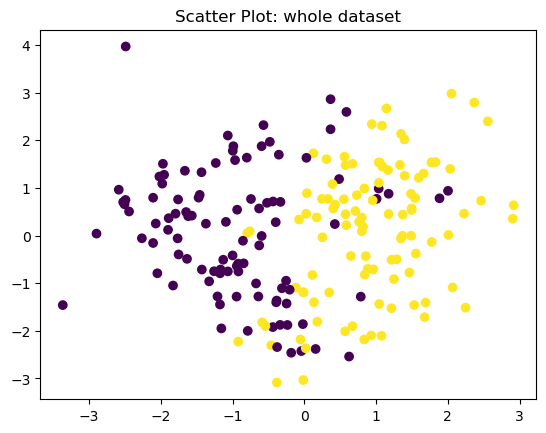

In [5]:
# Create synthetic data for binary classification
X, y = make_classification(n_samples=200, n_features=input_size, n_informative=2, n_redundant=0, n_classes=2, random_state=42)

#color = []
#for i in range (len(y)):
#    if y[i]==1:
#        color.append ('b')
#    else:
#        color.append('r')
        
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Scatter Plot: whole dataset')

plt.show()

In [6]:
# Normalize X to the range [0, 1] for quantization
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

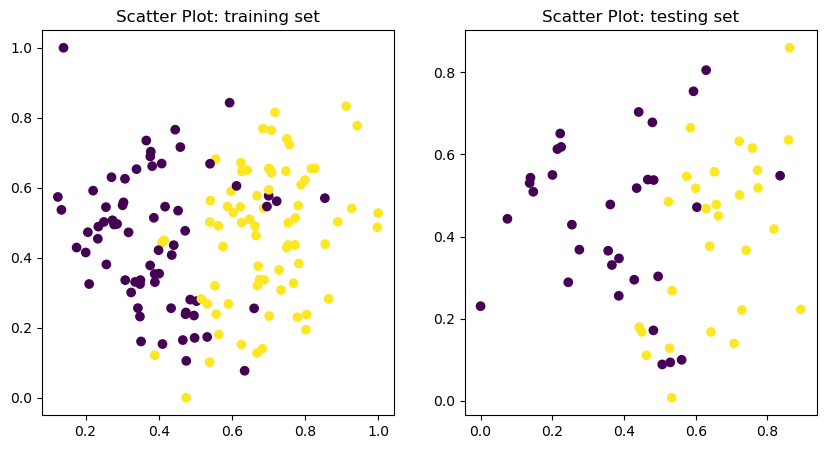

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train)
ax1.set_title('Scatter Plot: training set')

# Second subplot
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax2.set_title('Scatter Plot: testing set')

plt.show()


In [8]:
# Quantize continuous features into 3-bit binary representation
def quantize_to_binary(data, n_bits=3):
    n_levels = 2 ** n_bits
    quantized = np.floor(data * n_levels).astype(int)
    quantized[quantized >= n_levels] = n_levels - 1  # Handle edge cases
    binary_features = np.array([np.unpackbits(np.uint8(q), count=n_bits, bitorder='little') for q in quantized.flatten()])
    return binary_features.reshape(data.shape[0], -1)


In [9]:
# Reservoir initialization
def initialize_reservoir(input_size, n_reservoir, alpha):
    # Randomly initialize input weights and reservoir weights
    W_in = np.random.uniform(-0.5, 0.5, (n_reservoir, input_size))
    W_res = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
    
    # Scale the reservoir weights to ensure the spectral radius is less than 1
    spectral_radius = max(abs(np.linalg.eigvals(W_res)))
    W_res *= alpha / spectral_radius
    
    return W_in, W_res


In [10]:
# Function to compute reservoir states
def compute_reservoir_states(X, W_in, W_res, rho=0.99):
    n_samples, _ = X.shape
    n_reservoir = W_res.shape[0]
    
    # Initialize reservoir states
    states = np.zeros((n_samples, n_reservoir))
    state = np.zeros(n_reservoir)
    
    for t in range(n_samples):
        # Update reservoir state using tanh activation function
        state = np.tanh(np.dot(W_in, X[t]) + np.dot(W_res, state))
        states[t] = state
    
    return states


In [11]:
# Initialize reservoir
W_in, W_res = initialize_reservoir(input_size, n_reservoir, alpha)
#print(W_in)

In [12]:
# Compute reservoir states for training and testing sets
print(X_train.shape)
print(W_in.shape)
print(W_res.shape)
print(X_test.shape)

X_train_reservoir = compute_reservoir_states(X_train, W_in, W_res)
X_test_reservoir = compute_reservoir_states(X_test, W_in, W_res)
print(X_train_reservoir.shape)

(140, 2)
(100, 2)
(100, 100)
(60, 2)
(140, 100)


In [13]:
# Train a linear classifier on the reservoir states
from sklearn.linear_model import LogisticRegression

In [14]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_reservoir, y_train)

print(X_test_reservoir.shape)
print(y_train.shape)

(60, 100)
(140,)


In [15]:
# Make predictions
y_pred = model.predict(X_test_reservoir)


In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


In [17]:
# Train a linear classifier on the input states without reservoir
from sklearn.linear_model import LogisticRegression

In [18]:
# Create and train the logistic regression model
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [19]:
# Make predictions
y_pred1 = model1.predict(X_test)


In [20]:
# Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy1:.2f}")

Accuracy: 0.83


### Quantum Reservoir computing


In [35]:
# Import necessary libraries
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit.visualization import circuit_drawer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from itertools import product


In [32]:
# Quantize training and testing features
X_train_binary = quantize_to_binary(X_train)
X_test_binary = quantize_to_binary(X_test)

#print(X_train_binary)

In [36]:
# Step 1: Define the Quantum Reservoir (Random Quantum Circuit)
def create_quantum_reservoir(n_qubits, depth):
    """Creates a random quantum reservoir with n_qubits and depth layers."""
    qc = QuantumCircuit(n_qubits)
    for _ in range(depth):
        for qubit in range(n_qubits):
            qc.rx(np.random.uniform(0, np.pi), qubit)
            qc.rz(np.random.uniform(0, np.pi), qubit)
        for qubit in range(n_qubits - 1):
            qc.cx(qubit, qubit + 1)
    return qc

# Step 2: Input Encoding (Amplitude Encoding)
def encode_input(input_data, n_qubits):
    """Encodes classical input data into a quantum state."""
    qc = QuantumCircuit(n_qubits)
    for idx, bit in enumerate(input_data):
        if bit == 1:
            qc.x(idx)
    return qc

# Step 3: Evolve the state with the quantum reservoir
def evolve_with_reservoir(qc, reservoir_circuit):
    """Evolves the input state using the quantum reservoir."""
    qc = qc.compose(reservoir_circuit)
    return qc

# Step 4: Measurement
def measure_output(qc, n_qubits):
    """Measures the quantum state in the computational basis using the Sampler primitive."""
    # Add classical bits to the circuit for measurement
    qc_with_classical = QuantumCircuit(n_qubits, n_qubits)
    qc_with_classical.compose(qc, inplace=True)
    qc_with_classical.measure(range(n_qubits), range(n_qubits))
    
    # Use Sampler to measure
    sampler = Sampler()
    result = sampler.run([qc_with_classical]).result()
    counts = result.quasi_dists[0].binary_probabilities()
    return counts

def generate_n_bit_strings(n):
    """
    Generate all possible n-bit binary strings.

    Parameters:
    n (int): Number of bits.

    Returns:
    list: A list of n-bit binary strings.
    """
    return [''.join(bits) for bits in product('01', repeat=n)]


In [39]:
# Create the quantum reservoir
n_qubits = 6
depth = 3
reservoir_circuit = create_quantum_reservoir(n_qubits, depth)

# Classical readout data
train_features = []
test_features = []

# Generating n bit strings
n_bit_strings = generate_n_bit_strings(n)

# Simulate quantum reservoir computing
for sample in X_train_binary:
    input_qc = encode_input(sample, n_qubits)
    evolved_qc = evolve_with_reservoir(input_qc, reservoir_circuit)
    counts = measure_output(evolved_qc, n_qubits)
    # Use the counts of |000000> to |111111> as the 64 features for the classical output layer model
    tmp = []
    for string in n_bit_strings:
        count = counts.get(string, 0)
        tmp.append(count)
    train_features.append(tmp)
    
for sample in X_test_binary:
    input_qc = encode_input(sample, n_qubits)
    evolved_qc = evolve_with_reservoir(input_qc, reservoir_circuit)
    counts = measure_output(evolved_qc, n_qubits)
    tmp = []
    for string in n_bit_strings:
        count = counts.get(string, 0)
        tmp.append(count)
    test_features.append(tmp)
    

# Step 6: Classical readout using Logistic Regression
classifier = LogisticRegression()
classifier.fit(train_features, y_train)


# Predict and evaluate
y_pred = classifier.predict(test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead

C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead

C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead

C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:17: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead

C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)
C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead

Accuracy: 60.00%


C:\Users\demol\AppData\Local\Temp\ipykernel_46488\2376844806.py:28: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  counts = measure_output(evolved_qc, n_qubits)


C:\Users\demol\AppData\Local\Temp\ipykernel_46488\4223283071.py:9: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  example_counts = measure_output(example_qc_with_classical, n_qubits)


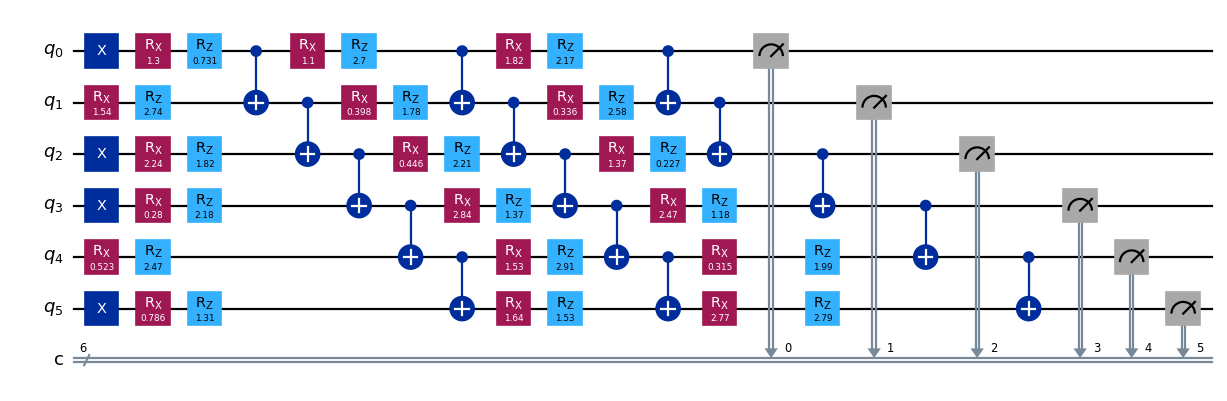

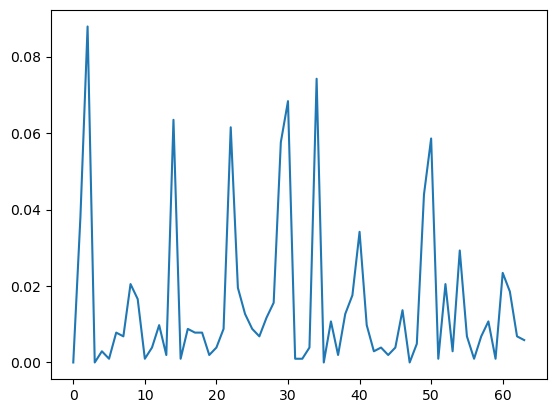

In [49]:
# Step 7: Visualize the Quantum Circuit 
# Display the reservoir circuit with example input encoding
example_input = [1, 0, 1, 1, 0, 1]
example_qc = encode_input(example_input, n_qubits)
example_qc = evolve_with_reservoir(example_qc, reservoir_circuit)
example_qc_with_classical = QuantumCircuit(n_qubits, n_qubits)
example_qc_with_classical.compose(example_qc, inplace=True)
example_qc_with_classical.measure(range(n_qubits), range(n_qubits))
example_counts = measure_output(example_qc_with_classical, n_qubits)
tmp = []
example_probabilities = []
for string in n_bit_strings:
        count = example_counts.get(string, 0)
        tmp.append(count)
tmp=np.array(tmp)
total_tmp=np.sum(tmp)
tmp=tmp/total_tmp
plt.plot(tmp)

circuit_drawer(example_qc_with_classical, output='mpl', scale=0.8)